## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/07/'
IMAGE_DIMS = (84,84,3)#class0
#IMAGE_DIMS = (84,84,3)#class1
#IMAGE_DIMS = (56,56,3)#class2
#IMAGE_DIMS = (42,42,3)#class3
#IMAGE_DIMS = (26,26,3)#class4

TRAIN_CLASS = 0
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights-medium1-class0.h5'

Y_CHANGE = [[1,2,3,4,5],[0]]
TRAIN_WEIGHT_RAW = (1,0.2,0.2,0.2,0.2,0.2)
TRAIN_WEIGHT = (1,1)
TEST_WEIGHT_RAW = (1,0.2,0.2,0.2,0.2,0.2)
TEST_WEIGHT = (1,1)

SAVE_MODEL_FILE = None
LOAD_WEIGHTS_FILE = SAVE_WEIGHTS_FILE
LOAD_MODEL_FILE = None
INPUT_DATASET_NAME = 'lion-patches-0px'

RECREATE_OUTPUT_DIR = True
RUN_TRAINING = True

TRAIN_EPOCHS = 10
INPUT_RANGE = 1
DEBUG = False

BATCH_SIZE=48

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-06-11 13:39:45,548 INFO Output dirs created


### Prepare train, validate and test data flows

In [4]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

#used for image augmentation (creating new images for balancing)
image_augmentation_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

#applied to all images during training
image_randomize_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TRAIN_WEIGHT_RAW,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=0.7)
train_image_generator = utils.ImageAugmentationXYGenerator(train_balance_generator, image_randomize_generator)
train_generator = utils.ClassBalancerGeneratorXY(train_image_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TRAIN_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=1,
                                                         change_y=Y_CHANGE)
#train_generator = utils.ChangeXYGenerator(train_image_generator, categorical_to_boolean)
logger.info('train size=' + str(train_generator.size) + ' batches=' + str(train_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT_RAW,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.7, end_ratio=0.85)
valid_generator = utils.ClassBalancerGeneratorXY(valid_balance_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=1,
                                                         change_y=Y_CHANGE)
logger.info('valid size=' + str(valid_generator.size) + ' batches=' + str(valid_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT_RAW,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.85, end_ratio=1)
test_generator = utils.ClassBalancerGeneratorXY(test_balance_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=1,
                                                         change_y=Y_CHANGE)
logger.info('test size=' + str(test_generator.size) + ' batches=' + str(test_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-06-11 13:39:45,589 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-84-84.h5 as input
2017-06-11 13:39:45,604 INFO preparing train data
2017-06-11 13:39:45,606 INFO loading input data for class distribution analysis...
2017-06-11 13:39:45,607 INFO loading Y from raw dataset
2017-06-11 13:39:45,609 INFO > [started] generator dump...


1600/2263

2017-06-11 13:39:46,004 INFO > [done]    generator dump (395.147 ms)
2017-06-11 13:39:46,007 INFO raw sample class distribution
2017-06-11 13:39:46,008 INFO 0: 78
2017-06-11 13:39:46,010 INFO 1: 45
2017-06-11 13:39:46,011 INFO 2: 675
2017-06-11 13:39:46,013 INFO 3: 150
2017-06-11 13:39:46,014 INFO 4: 281
2017-06-11 13:39:46,015 INFO 5: 1034
2017-06-11 13:39:46,017 INFO overall output samples per class: 90
2017-06-11 13:39:46,018 INFO augmentation/undersampling ratio per class
2017-06-11 13:39:46,020 INFO SETUP FLOW 0 0.7
2017-06-11 13:39:46,021 INFO calculating source range according to start/end range of the desired output..
2017-06-11 13:39:46,023 INFO output distribution for this flow
2017-06-11 13:39:46,024 INFO 0: 62 (1.15)
2017-06-11 13:39:46,026 INFO 1: 12 (0.40)
2017-06-11 13:39:46,027 INFO 2: 12 (0.03)
2017-06-11 13:39:46,028 INFO 3: 12 (0.12)
2017-06-11 13:39:46,029 INFO 4: 12 (0.06)
2017-06-11 13:39:46,031 INFO 5: 12 (0.02)
2017-06-11 13:39:46,034 INFO source range: 0-1836 (

1600/2263

2017-06-11 13:39:46,918 INFO > [done]    generator dump (333.349 ms)
2017-06-11 13:39:46,921 INFO raw sample class distribution
2017-06-11 13:39:46,923 INFO 0: 78
2017-06-11 13:39:46,924 INFO 1: 45
2017-06-11 13:39:46,926 INFO 2: 675
2017-06-11 13:39:46,927 INFO 3: 150
2017-06-11 13:39:46,929 INFO 4: 281
2017-06-11 13:39:46,931 INFO 5: 1034
2017-06-11 13:39:46,932 INFO overall output samples per class: 90
2017-06-11 13:39:46,934 INFO augmentation/undersampling ratio per class
2017-06-11 13:39:46,935 INFO SETUP FLOW 0.7 0.85
2017-06-11 13:39:46,936 INFO calculating source range according to start/end range of the desired output..
2017-06-11 13:39:46,938 INFO output distribution for this flow
2017-06-11 13:39:46,939 INFO 0: 13 (1.15)
2017-06-11 13:39:46,941 INFO 1: 2 (0.40)
2017-06-11 13:39:46,942 INFO 2: 2 (0.03)
2017-06-11 13:39:46,943 INFO 3: 2 (0.12)
2017-06-11 13:39:46,945 INFO 4: 2 (0.06)
2017-06-11 13:39:46,946 INFO 5: 2 (0.02)
2017-06-11 13:39:46,949 INFO source range: 1588-1894 

1600/2263

2017-06-11 13:39:47,423 INFO > [done]    generator dump (324.211 ms)
2017-06-11 13:39:47,426 INFO raw sample class distribution
2017-06-11 13:39:47,427 INFO 0: 78
2017-06-11 13:39:47,429 INFO 1: 45
2017-06-11 13:39:47,430 INFO 2: 675
2017-06-11 13:39:47,431 INFO 3: 150
2017-06-11 13:39:47,433 INFO 4: 281
2017-06-11 13:39:47,434 INFO 5: 1034
2017-06-11 13:39:47,436 INFO overall output samples per class: 90
2017-06-11 13:39:47,437 INFO augmentation/undersampling ratio per class
2017-06-11 13:39:47,438 INFO SETUP FLOW 0.85 1
2017-06-11 13:39:47,440 INFO calculating source range according to start/end range of the desired output..
2017-06-11 13:39:47,441 INFO output distribution for this flow
2017-06-11 13:39:47,442 INFO 0: 13 (1.15)
2017-06-11 13:39:47,444 INFO 1: 2 (0.40)
2017-06-11 13:39:47,445 INFO 2: 2 (0.03)
2017-06-11 13:39:47,446 INFO 3: 2 (0.12)
2017-06-11 13:39:47,448 INFO 4: 2 (0.06)
2017-06-11 13:39:47,449 INFO 5: 2 (0.02)
2017-06-11 13:39:47,452 INFO source range: 1869-2090 (2

In [5]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

if(DEBUG):
    logger.info('BALANCE GENERATOR DATA')
    #dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
    X_train, Y_train = utils.dump_xy_to_array(train_generator.flow(), train_generator.size, x=False, y=True)
    logger.info('y ' + str(np.shape(Y_train)))
    #logger.info(str(utils.class_distribution(Y_train)))

    for xs,ys in train_generator.flow():
        utils.show_images(xs, image_labels=ys, cols=10, is_bgr=True, size=2)
        break

### Prepare CNN model

In [6]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)
else:
    model = lions.convnet_medium1_boolean(IMAGE_DIMS)
    logger.info('loaded model from function convnet_medium1_single')
    

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    model.load_weights(LOAD_WEIGHTS_FILE)
    logger.info('Loaded model weights from ' + LOAD_WEIGHTS_FILE)

logger.info('Model prepared')

2017-06-11 13:39:47,595 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:164: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_initializer="glorot_uniform", padding="same")`
  model.add(convolutional.Conv2D(64, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:166: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", kernel_initializer="glorot_uniform", padding="same")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:168: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", kernel_initializer="glorot_uniform", padding="same")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same'

## Train model

In [7]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator.flow(),
                  steps_per_epoch = train_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_generator.flow(), 
                  validation_steps = valid_generator.nr_batches,
                  verbose = 1)

    if(SAVE_MODEL_FILE!=None):
        with open(SAVE_MODEL_FILE, 'w') as model_file:
            model_file.write(model.to_yaml())
            logger.info('Saved last model to ' + SAVE_MODEL_FILE)
    
    if(SAVE_WEIGHTS_FILE!=None):
        model.save_weights(SAVE_WEIGHTS_FILE)
        logger.info('Saved last weights to ' + SAVE_WEIGHTS_FILE)


2017-06-11 13:39:47,772 INFO Starting CNN training...


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-11 13:39:47,978 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-11 13:39:47,984 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-11 13:39:47,988 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-11 13:39:47,995 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-11 13:39:48,001 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-11 13:39:48,007 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-11 13:39:48,011 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-11 13:39:48,018 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-11 13:39:48,023 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-11 13:39:48,029 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-11 13:39:48,033 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-11 13:39:48,040 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-11 13:39:48,046 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-11 13:39:48,055 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-11 13:39:48,059 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-11 13:39:48,066 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-11 13:39:48,072 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-11 13:39:48,077 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-11 13:39:48,081 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-11 13:39:48,088 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-11 13:39:48,094 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-11 13:39:48,103 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-11 13:39:48,107 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-11 13:39:48,114 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=5, validation_data=<generator..., verbose=1, epochs=10, callbacks=[<keras.ca..., validation_steps=1)`
2017-06-11 13:39:48,735 INFO starting new flow...
2017-06-11 13:39:48,738 INFO starting new flow...


Epoch 1/10
Epoch 1/10
4/5 [=======================>......] - ETA: 2s - loss: 1.1947 - acc: 0.5990 

2017-06-11 13:39:58,966 INFO starting new flow...
2017-06-11 13:39:58,968 INFO starting new flow...


Epoch 00000: val_acc improved from -inf to 0.25000, saving model to ../../output/kaggle-sea-lion/07/weights/weights-00-0.25.h5
5/5 [==============================] - 12s - loss: 1.1029 - acc: 0.5292 - val_loss: 0.6992 - val_acc: 0.2500
Epoch 2/10
Epoch 2/10
5/5 [==============================] - 12s - loss: 0.6761 - acc: 0.5958 - val_loss: 0.7925 - val_acc: 0.3542
Epoch 3/10
Epoch 3/10
5/5 [==============================] - 12s - loss: 0.6161 - acc: 0.6583 - val_loss: 0.5861 - val_acc: 0.7500
Epoch 4/10
Epoch 4/10
5/5 [==============================] - 11s - loss: 0.6723 - acc: 0.6250 - val_loss: 0.6176 - val_acc: 0.6458
Epoch 5/10
Epoch 5/10
5/5 [==============================] - 11s - loss: 0.6287 - acc: 0.6375 - val_loss: 0.7277 - val_acc: 0.4167
Epoch 6/10
Epoch 6/10
5/5 [==============================] - 11s - loss: 0.5948 - acc: 0.6708 - val_loss: 0.6680 - val_acc: 0.6042
Epoch 7/10
Epoch 7/10
5/5 [==============================] - 11s - loss: 0.6096 - acc: 0.6167 - val_loss: 0.6

2017-06-11 13:41:45,547 INFO Saved last weights to ../../output/kaggle-sea-lion/07/last-weights-medium1-class0.h5


### Epoch accuracy/loss

2017-06-11 13:41:45,559 INFO Training info


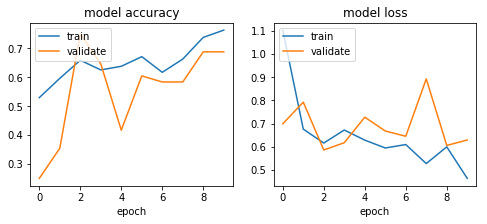

In [8]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

2017-06-11 13:41:45,812 INFO Evaluating model performance (40 samples)...
2017-06-11 13:41:45,821 INFO starting new flow...
2017-06-11 13:41:45,824 INFO starting new flow...
2017-06-11 13:41:46,875 INFO Accuracy: 0.854166686535 - Loss: 0.325673669577
2017-06-11 13:41:46,876 INFO Predicting Y for detailed analysis...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/cnn.py:59: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(self.y_ds==None):
2017-06-11 13:41:48,362 INFO Accuracy: 0.5
2017-06-11 13:41:48,364 INFO Number of test samples: 40
2017-06-11 13:41:48,365 INFO Kappa score: 0.137931034483 (-1 bad; 0 just luck; 1 great)
2017-06-11 13:41:48,367 INFO 
             precision    recall  f1-score   support

        any       1.00      0.17      0.29        24
       male       0.44      1.00      0.62        16

avg / total       0.78      0.50      0.42        40

2017-06-11 13:41:48,368 INFO Accuracy per class:
2017-06-11 1

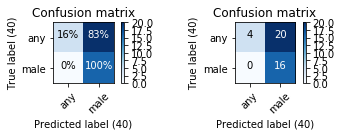

In [9]:
cnn.evaluate_dataset_keras(test_generator.flow(), 
                       test_generator.nr_batches, 
                       test_generator.size, 
                       model, 
                       class_labels=['any', 'male'])

In [10]:
if(DEBUG):
    a = test_generator.flow()
    cnn.show_predictions(a, 50, model)